# Document Tampering Detection - Model Training

This notebook trains a CNN-based binary classification model to detect document tampering.  
It uses the **Error Level Analysis (ELA)** technique and a dataset of original and tampered ID documents from multiple countries, based on the approach from the [document-tampering-detection](document-tampering-detection/) reference repository.

**Pipeline:**
1. Parse and normalize the inconsistent folder structure  
2. Apply ELA preprocessing  
3. Train/validate/test split (card-level, no leakage)  
4. Build and train a CNN  
5. Evaluate performance  
6. Save the model

## 1. Import Required Libraries

In [1]:
import os
import re
import json
import warnings
import itertools
from pathlib import Path
from datetime import datetime
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image, ImageChops, ImageEnhance

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.10.0+cpu
Device: cpu
CUDA available: False


## 2. Configure Data Paths and Explore Directory Structure

In [2]:
DATA_ROOT = Path(r"data/Forgery Data 24 Feb 26")

# Walk and summarize structure
countries = []
total_images = 0
for root, dirs, files in os.walk(DATA_ROOT):
    jpg_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if jpg_files:
        total_images += len(jpg_files)
    rel = Path(root).relative_to(DATA_ROOT)
    parts = rel.parts
    if len(parts) >= 1 and parts[0] not in countries:
        countries.append(parts[0])

print(f"Data root     : {DATA_ROOT.resolve()}")
print(f"Countries     : {len(countries)}")
print(f"Total images  : {total_images}")
print(f"\nCountry list  : {countries}")

Data root     : C:\Users\Shubham\Desktop\DocumentForgery\data\Forgery Data 24 Feb 26
Countries     : 20
Total images  : 115

Country list  : ['afgan', 'Bahrain', 'botwswana', 'Colombia', 'ecuador', 'India', 'Kuwait', 'Maurtania', 'Moldova', 'Morocco', 'Panama', 'Philippines', 'Qatar', 'Saudi', 'spain', 'Tunisia', 'Turkey', 'UAE', 'Uganda', 'US']


## 3. Parse and Normalize Folder Structure (Handle Inconsistent Naming)

The dataset has inconsistent naming conventions:
- `original`, `Original`, `orignal`, `origina l` → **original (label 0)**  
- `tampered 1`, `Tampered 1`, `tampered 2`, `Tampered 2`, `Tampered  1` → **tampered (label 1)**  
- Some countries (Ecuador, Philippines) have `card 1/card 1/` as original  
- India has subcategories (Aadhar, Pan)  
- Morocco has no card subfolder

In [3]:
def classify_folder(folder_name):
    """Classify a folder as 'original' or 'tampered' based on its name."""
    name = folder_name.strip().lower()
    name = re.sub(r'\s+', ' ', name)  # normalize spaces
    
    if re.match(r'^orig', name):  # original, orignal, origina l
        return 'original'
    elif re.match(r'^tamper', name):  # tampered 1, tampered 2
        return 'tampered'
    elif name.startswith('card'):
        # Ecuador/card 1/card 1/ and Philippines/card 1/card 1/ → treat as original
        return 'original'
    return None


def parse_dataset(data_root):
    """Parse the entire dataset into a DataFrame with labels and metadata."""
    records = []
    
    for root, dirs, files in os.walk(data_root):
        jpg_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if not jpg_files:
            continue
        
        rel = Path(root).relative_to(data_root)
        parts = rel.parts
        folder_name = parts[-1] if parts else ''
        
        label_str = classify_folder(folder_name)
        if label_str is None:
            print(f"  [SKIP] Cannot classify folder: {rel}")
            continue
        
        label = 0 if label_str == 'original' else 1
        country = parts[0] if len(parts) >= 1 else 'unknown'
        
        # Build a card_id for group-level splitting (prevents data leakage)
        card_id = f"{country}"
        for p in parts[1:]:
            p_lower = p.strip().lower()
            if p_lower.startswith('card') or p_lower in ['aadhar', 'pan', 'kansas', 'maryland', 'virginia']:
                card_id += f"_{p}"
        
        for f in jpg_files:
            file_path = os.path.join(root, f)
            records.append({
                'file_path': file_path,
                'label': label,
                'label_str': label_str,
                'country': country,
                'card_id': card_id,
                'variant': folder_name
            })
    
    return pd.DataFrame(records)


df = parse_dataset(DATA_ROOT)
print(f"Total images parsed: {len(df)}")
print(f"\nClass distribution:\n{df['label_str'].value_counts()}")
print(f"\nImages per country:")
print(df['country'].value_counts())
print(f"\nUnique card groups: {df['card_id'].nunique()}")
df.head(10)

Total images parsed: 115

Class distribution:
label_str
tampered    73
original    42
Name: count, dtype: int64

Images per country:
country
Moldova        18
Colombia       15
Maurtania      15
Bahrain         8
Kuwait          8
afgan           6
Turkey          6
US              6
India           4
botwswana       3
ecuador         3
Morocco         3
Philippines     3
Qatar           3
Saudi           3
spain           3
Panama          2
Tunisia         2
UAE             2
Uganda          2
Name: count, dtype: int64

Unique card groups: 44


,file_path,label,label_str,country,card_id,variant
0,data\Forgery Data 24 Feb 26\afgan\card 1\origi...,0,original,afgan,afgan_card 1,origina l
1,data\Forgery Data 24 Feb 26\afgan\card 1\tampe...,1,tampered,afgan,afgan_card 1,tampered 1
2,data\Forgery Data 24 Feb 26\afgan\card 1\tampe...,1,tampered,afgan,afgan_card 1,tampered 2
3,data\Forgery Data 24 Feb 26\afgan\card 2\origi...,0,original,afgan,afgan_card 2,original
4,data\Forgery Data 24 Feb 26\afgan\card 2\tampe...,1,tampered,afgan,afgan_card 2,tampered 1
5,data\Forgery Data 24 Feb 26\afgan\card 2\tampe...,1,tampered,afgan,afgan_card 2,tampered 2
6,data\Forgery Data 24 Feb 26\Bahrain\card 1\Ori...,0,original,Bahrain,Bahrain_card 1,Original
7,data\Forgery Data 24 Feb 26\Bahrain\card 1\Tam...,1,tampered,Bahrain,Bahrain_card 1,Tampered 1
8,data\Forgery Data 24 Feb 26\Bahrain\card 2\ori...,0,original,Bahrain,Bahrain_card 2,original
9,data\Forgery Data 24 Feb 26\Bahrain\card 2\tam...,1,tampered,Bahrain,Bahrain_card 2,tampered 1


## 4. Load Images and Apply Error Level Analysis (ELA)

Error Level Analysis (ELA) detects compression-level differences in JPEG images. Tampered regions typically show different ELA patterns than the rest of the image.

In [4]:
IMAGE_SIZE = 128  # Match reference repository

def convert_to_ela_image(path, quality=90):
    """Convert an image to its ELA representation."""
    temp_filename = 'temp_ela_resaved.jpg'
    try:
        im = Image.open(path).convert('RGB')
        im.save(temp_filename, 'JPEG', quality=quality)
        resaved_im = Image.open(temp_filename)
        
        ela_im = ImageChops.difference(im, resaved_im)
        extrema = ela_im.getextrema()
        max_diff = max([ex[1] for ex in extrema])
        if max_diff == 0:
            max_diff = 1
        scale = 255.0 / max_diff
        ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
        
        im.close()
        resaved_im.close()
        return ela_im
    except Exception as e:
        print(f"  [ERROR] ELA failed for {path}: {e}")
        return None
    finally:
        if os.path.exists(temp_filename):
            os.remove(temp_filename)


# Process all images through ELA
X = []
Y = []
valid_indices = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Converting to ELA"):
    ela_img = convert_to_ela_image(row['file_path'])
    if ela_img is not None:
        img_array = np.array(ela_img.resize((IMAGE_SIZE, IMAGE_SIZE))) / 255.0
        X.append(img_array)
        Y.append(row['label'])
        valid_indices.append(idx)
        ela_img.close()

X = np.array(X)
Y = np.array(Y)

# Keep only valid entries in the dataframe
df_valid = df.loc[valid_indices].reset_index(drop=True)

print(f"\nDataset shape: X={X.shape}, Y={Y.shape}")
print(f"Class distribution: Original={np.sum(Y==0)}, Tampered={np.sum(Y==1)}")
print(f"Memory usage: {X.nbytes / 1e6:.1f} MB")

Converting to ELA: 100%|██████████| 115/115 [00:16<00:00,  7.07it/s]


Dataset shape: X=(115, 128, 128, 3), Y=(115,)
Class distribution: Original=42, Tampered=73
Memory usage: 45.2 MB


## 5. Exploratory Data Analysis - Dataset Statistics and Visualization

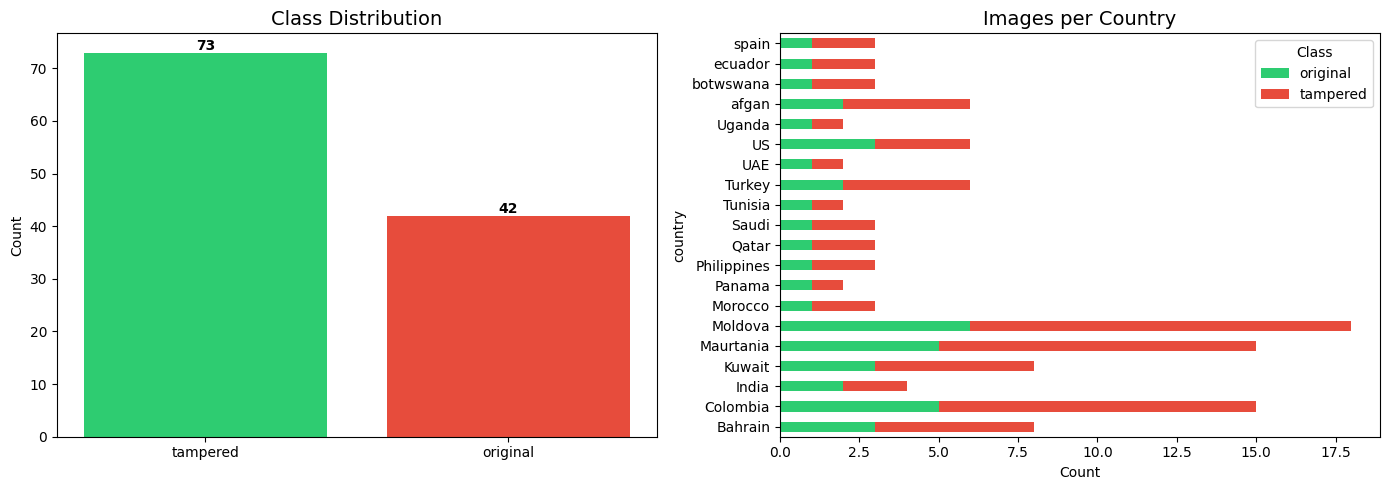

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class distribution
class_counts = df_valid['label_str'].value_counts()
axes[0].bar(class_counts.index, class_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution', fontsize=14)
axes[0].set_ylabel('Count')
for i, (label, count) in enumerate(zip(class_counts.index, class_counts.values)):
    axes[0].text(i, count + 0.5, str(count), ha='center', fontweight='bold')

# Per-country distribution
country_counts = df_valid.groupby(['country', 'label_str']).size().unstack(fill_value=0)
country_counts.plot(kind='barh', stacked=True, ax=axes[1], color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Images per Country', fontsize=14)
axes[1].set_xlabel('Count')
axes[1].legend(title='Class')

plt.tight_layout()
plt.show()

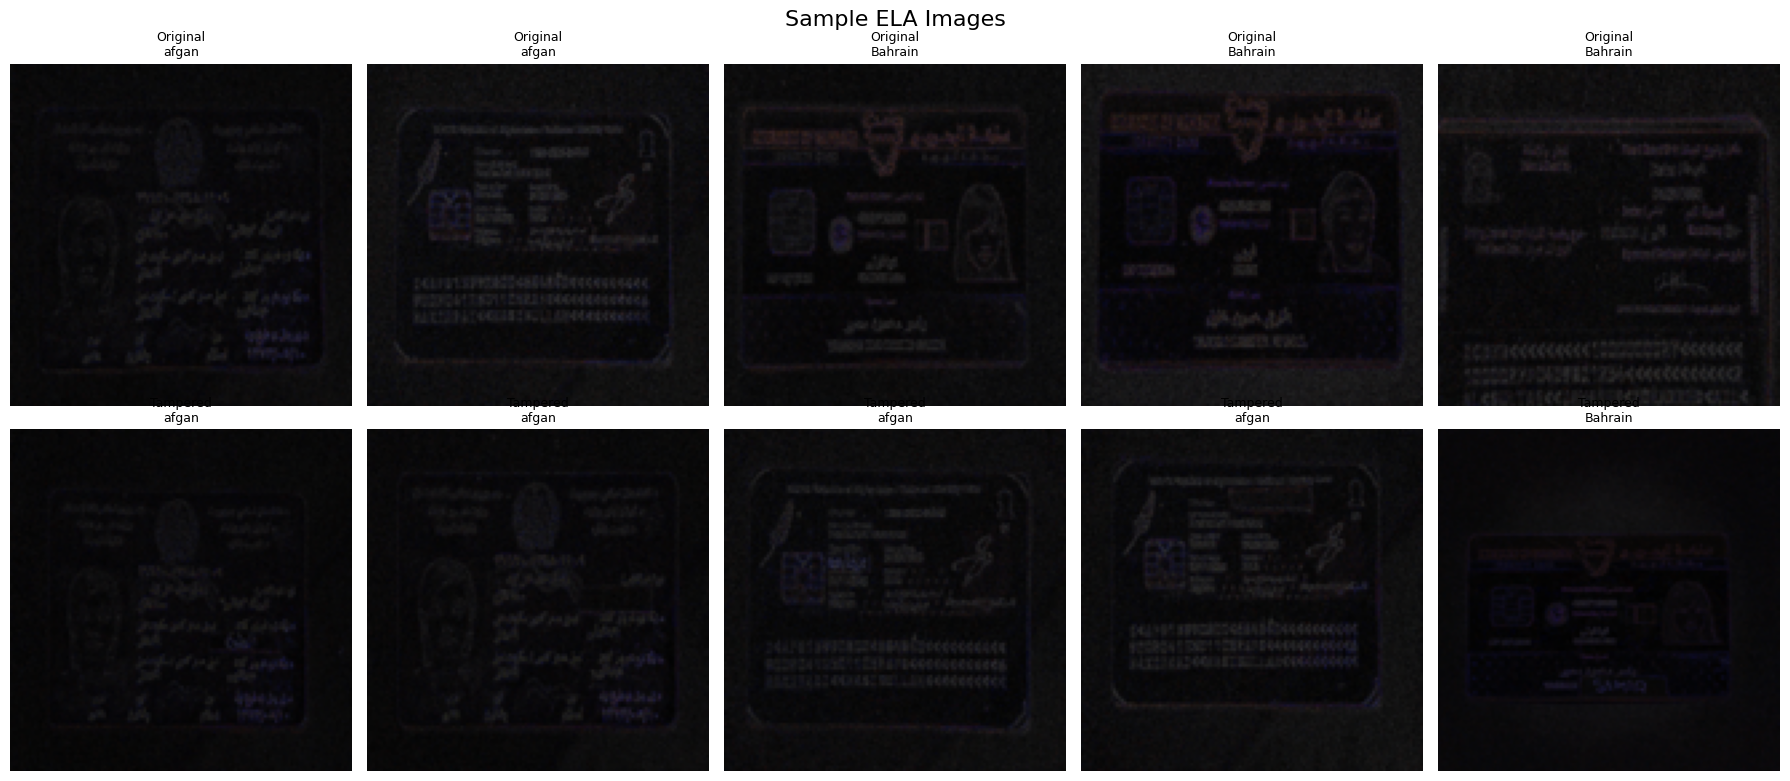

In [6]:
# Show sample ELA images: original vs tampered
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.suptitle('Sample ELA Images', fontsize=16)

orig_idx = np.where(Y == 0)[0]
tamp_idx = np.where(Y == 1)[0]

for i in range(5):
    if i < len(orig_idx):
        axes[0, i].imshow(X[orig_idx[i]])
        axes[0, i].set_title(f"Original\n{df_valid.loc[orig_idx[i], 'country']}", fontsize=9)
        axes[0, i].axis('off')

for i in range(5):
    if i < len(tamp_idx):
        axes[1, i].imshow(X[tamp_idx[i]])
        axes[1, i].set_title(f"Tampered\n{df_valid.loc[tamp_idx[i], 'country']}", fontsize=9)
        axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Tampered', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Image Augmentation Pipeline

Since the dataset is small (~115 images), **data augmentation is critical** to prevent overfitting.

In [7]:
import torchvision.transforms as transforms

# Training augmentation
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2),
])

print("Augmentation pipeline configured.")

Augmentation pipeline configured.


## 7. Split Dataset into Train, Validation, and Test Sets

**Card-level splitting** ensures that original and tampered versions of the same card don't appear in different splits (prevents data leakage).

In [12]:
# Group-aware splitting by card_id to prevent data leakage
groups = df_valid['card_id'].values

# First split: 70% train, 30% temp (val+test)
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, temp_idx = next(gss1.split(X, Y, groups))

X_train_np, Y_train_np = X[train_idx], Y[train_idx]
X_temp, Y_temp = X[temp_idx], Y[temp_idx]
groups_temp = groups[temp_idx]

# Second split: 50/50 of temp -> 15% val, 15% test
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
val_idx, test_idx = next(gss2.split(X_temp, Y_temp, groups_temp))

X_val_np, Y_val_np = X_temp[val_idx], Y_temp[val_idx]
X_test_np, Y_test_np = X_temp[test_idx], Y_temp[test_idx]

print(f"Train : {X_train_np.shape[0]} samples | Original: {np.sum(Y_train_np==0)}, Tampered: {np.sum(Y_train_np==1)}")
print(f"Val   : {X_val_np.shape[0]} samples | Original: {np.sum(Y_val_np==0)}, Tampered: {np.sum(Y_val_np==1)}")
print(f"Test  : {X_test_np.shape[0]} samples | Original: {np.sum(Y_test_np==0)}, Tampered: {np.sum(Y_test_np==1)}")

# Convert to PyTorch tensors (channels-first for PyTorch: N, C, H, W)
X_train_t = torch.FloatTensor(X_train_np.transpose(0, 3, 1, 2)).to(device)
Y_train_t = torch.LongTensor(Y_train_np).to(device)
X_val_t = torch.FloatTensor(X_val_np.transpose(0, 3, 1, 2)).to(device)
Y_val_t = torch.LongTensor(Y_val_np).to(device)
X_test_t = torch.FloatTensor(X_test_np.transpose(0, 3, 1, 2)).to(device)
Y_test_t = torch.LongTensor(Y_test_np).to(device)

# Create DataLoaders
BATCH_SIZE = 16
train_dataset = TensorDataset(X_train_t, Y_train_t)
val_dataset = TensorDataset(X_val_t, Y_val_t)
test_dataset = TensorDataset(X_test_t, Y_test_t)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"\nTensors on: {device}")

Train : 81 samples | Original: 28, Tampered: 53
Val   : 17 samples | Original: 7, Tampered: 10
Test  : 17 samples | Original: 7, Tampered: 10

Tensors on: cpu


## 8. Build CNN Model Architecture

Enhanced architecture based on the reference repository with additional Conv2D blocks and BatchNormalization for better feature extraction on a small dataset.

In [17]:
class TamperingDetectionCNN(nn.Module):
    """Lightweight CNN designed for small datasets."""
    def __init__(self, image_size=128):
        super().__init__()
        
        self.features = nn.Sequential(
            # Block 1: 128 -> 63 -> 31
            nn.Conv2d(3, 16, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Block 2: 31 -> 14
            nn.Conv2d(16, 32, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            # Block 3: 14 -> 5
            nn.Conv2d(32, 32, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        # Calculate flatten size
        with torch.no_grad():
            dummy = torch.zeros(1, 3, image_size, image_size)
            dummy = self.features(dummy)
            flat_size = dummy.view(1, -1).shape[1]
        
        self.classifier = nn.Sequential(
            nn.Linear(flat_size, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 2),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = TamperingDetectionCNN(IMAGE_SIZE).to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,} (much lighter for small dataset)")

TamperingDetectionCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout2d(p=0.25, inplace=False)
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)

Total parameters: 415,938 (much lighter for small dataset)


## 9. Compile and Train the Model

In [18]:
os.makedirs('model', exist_ok=True)

# Compute class weights to handle imbalance (42 original vs 73 tampered)
n_orig = np.sum(Y_train_np == 0)
n_tamp = np.sum(Y_train_np == 1)
total_n = n_orig + n_tamp
weight_orig = total_n / (2 * n_orig)
weight_tamp = total_n / (2 * n_tamp)
class_weights = torch.FloatTensor([weight_orig, weight_tamp]).to(device)
print(f"Class weights: Original={weight_orig:.3f}, Tampered={weight_tamp:.3f}")

# Loss with class weights and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, min_lr=1e-7)

EPOCHS = 100
PATIENCE = 20

# Training loop with early stopping
history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
best_val_acc = 0.0
best_model_state = None
patience_counter = 0

for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        # Apply augmentation
        augmented = torch.stack([train_transform(img.cpu()).to(device) for img in inputs])
        
        optimizer.zero_grad()
        outputs = model(augmented)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / total
    train_acc = correct / total
    
    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    # Record history
    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    # LR scheduler
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    lr_msg = f" | LR: {old_lr:.1e}->{new_lr:.1e}" if new_lr != old_lr else ""
    
    # Model checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        torch.save(best_model_state, 'model/best_tampering_model.pth')
        patience_counter = 0
        marker = ' *'
    else:
        patience_counter += 1
        marker = ''
    
    if (epoch + 1) % 10 == 0 or marker:
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | "
              f"Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}{marker}{lr_msg}")
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1} (no improvement for {PATIENCE} epochs)")
        break

# Restore best model
model.load_state_dict(best_model_state)
print(f"\nTraining completed. Best val accuracy: {best_val_acc:.4f}")

Class weights: Original=1.446, Tampered=0.764
Epoch   1/100 | Loss: 0.7056 Acc: 0.2875 | Val Loss: 0.6908 Val Acc: 0.4118 *
Epoch   2/100 | Loss: 0.6923 Acc: 0.5375 | Val Loss: 0.6930 Val Acc: 0.4706 *
Epoch   3/100 | Loss: 0.7038 Acc: 0.5250 | Val Loss: 0.7021 Val Acc: 0.5882 *
Epoch  10/100 | Loss: 0.6960 Acc: 0.3500 | Val Loss: 0.6889 Val Acc: 0.4118
Epoch  20/100 | Loss: 0.6964 Acc: 0.4000 | Val Loss: 0.6933 Val Acc: 0.5882
Epoch  21/100 | Loss: 0.6940 Acc: 0.5250 | Val Loss: 0.6920 Val Acc: 0.6471 *
Epoch  30/100 | Loss: 0.6960 Acc: 0.5250 | Val Loss: 0.6890 Val Acc: 0.5294
Epoch  40/100 | Loss: 0.6733 Acc: 0.6750 | Val Loss: 0.6808 Val Acc: 0.5882

Early stopping at epoch 41 (no improvement for 20 epochs)

Training completed. Best val accuracy: 0.6471


## 10. Plot Training and Validation Accuracy/Loss Curves

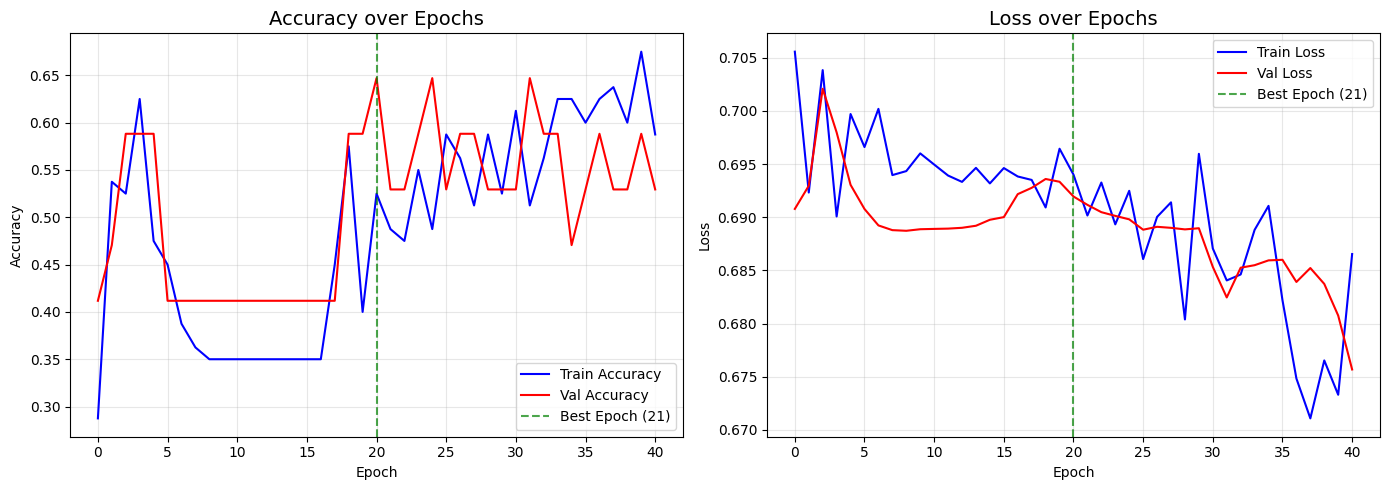

Best validation accuracy: 0.6471 at epoch 21


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history['accuracy'], label='Train Accuracy', color='blue')
axes[0].plot(history['val_accuracy'], label='Val Accuracy', color='red')
best_epoch = np.argmax(history['val_accuracy'])
axes[0].axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch+1})')
axes[0].set_title('Accuracy over Epochs', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history['loss'], label='Train Loss', color='blue')
axes[1].plot(history['val_loss'], label='Val Loss', color='red')
axes[1].axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch+1})')
axes[1].set_title('Loss over Epochs', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {max(history['val_accuracy']):.4f} at epoch {best_epoch+1}")

## 11. Evaluate Model on Test Set

In [20]:
# Load best model
model.load_state_dict(torch.load('model/best_tampering_model.pth', map_location=device))
model.eval()

# Predict on test set
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Y_pred_classes = np.array(all_preds)
Y_pred_prob = np.array(all_probs)
Y_true_classes = np.array(all_labels)

# Classification report
print("=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(
    Y_true_classes, Y_pred_classes,
    target_names=['Original', 'Tampered']
))

test_acc = np.mean(Y_pred_classes == Y_true_classes)
print(f"Test Accuracy: {test_acc:.4f}")

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Original       0.67      0.86      0.75         7
    Tampered       0.88      0.70      0.78        10

    accuracy                           0.76        17
   macro avg       0.77      0.78      0.76        17
weighted avg       0.79      0.76      0.77        17

Test Accuracy: 0.7647


## 12. Confusion Matrix and ROC Curve

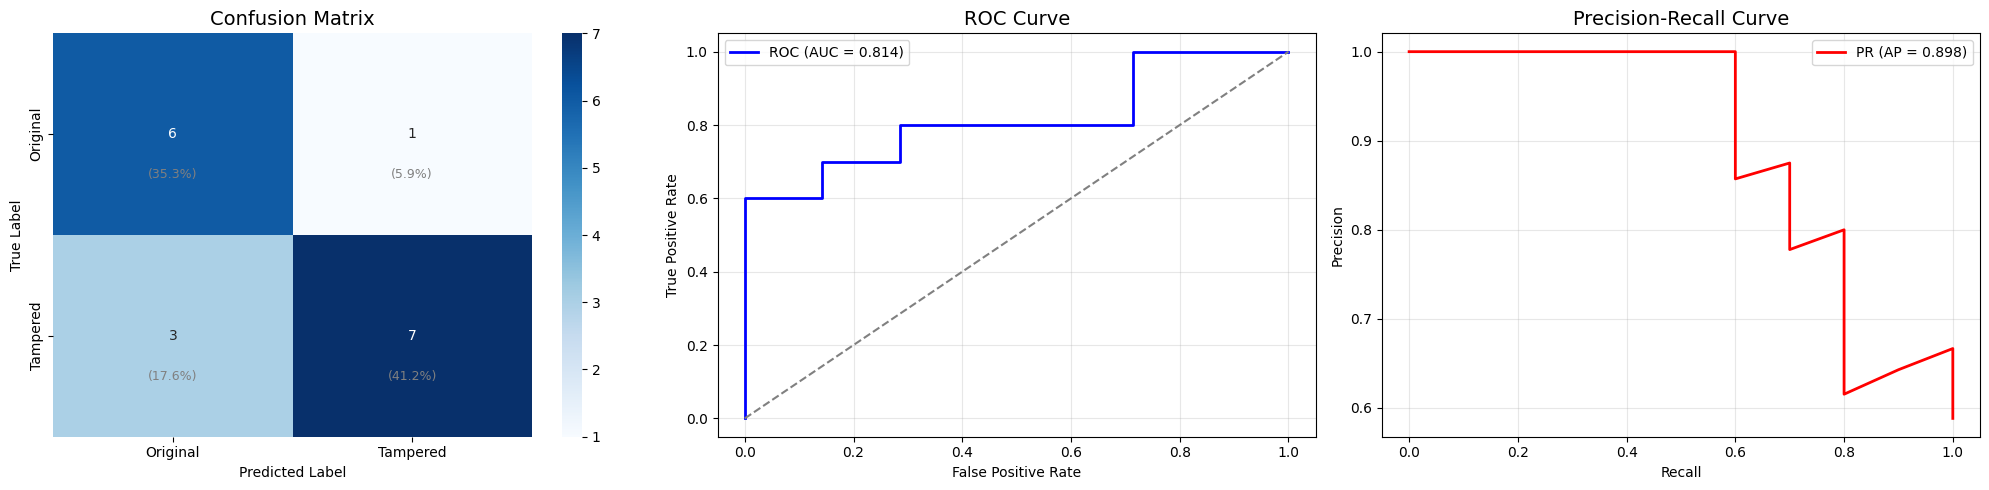

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# --- Confusion Matrix ---
cm = confusion_matrix(Y_true_classes, Y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Original', 'Tampered'],
            yticklabels=['Original', 'Tampered'])
axes[0].set_title('Confusion Matrix', fontsize=14)
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Add percentages
total = cm.sum()
for i in range(2):
    for j in range(2):
        pct = cm[i][j] / total * 100
        axes[0].text(j + 0.5, i + 0.7, f'({pct:.1f}%)', ha='center', va='center', fontsize=9, color='gray')

# --- ROC Curve ---
if len(np.unique(Y_true_classes)) > 1:
    fpr, tpr, _ = roc_curve(Y_true_classes, Y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axes[1].set_title('ROC Curve', fontsize=14)
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # --- Precision-Recall Curve ---
    precision, recall, _ = precision_recall_curve(Y_true_classes, Y_pred_prob[:, 1])
    ap = average_precision_score(Y_true_classes, Y_pred_prob[:, 1])
    axes[2].plot(recall, precision, color='red', lw=2, label=f'PR (AP = {ap:.3f})')
    axes[2].set_title('Precision-Recall Curve', fontsize=14)
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'Only one class in test set', ha='center')
    axes[2].text(0.5, 0.5, 'Only one class in test set', ha='center')

plt.tight_layout()
plt.show()

## 13. Test Predictions on Sample Images

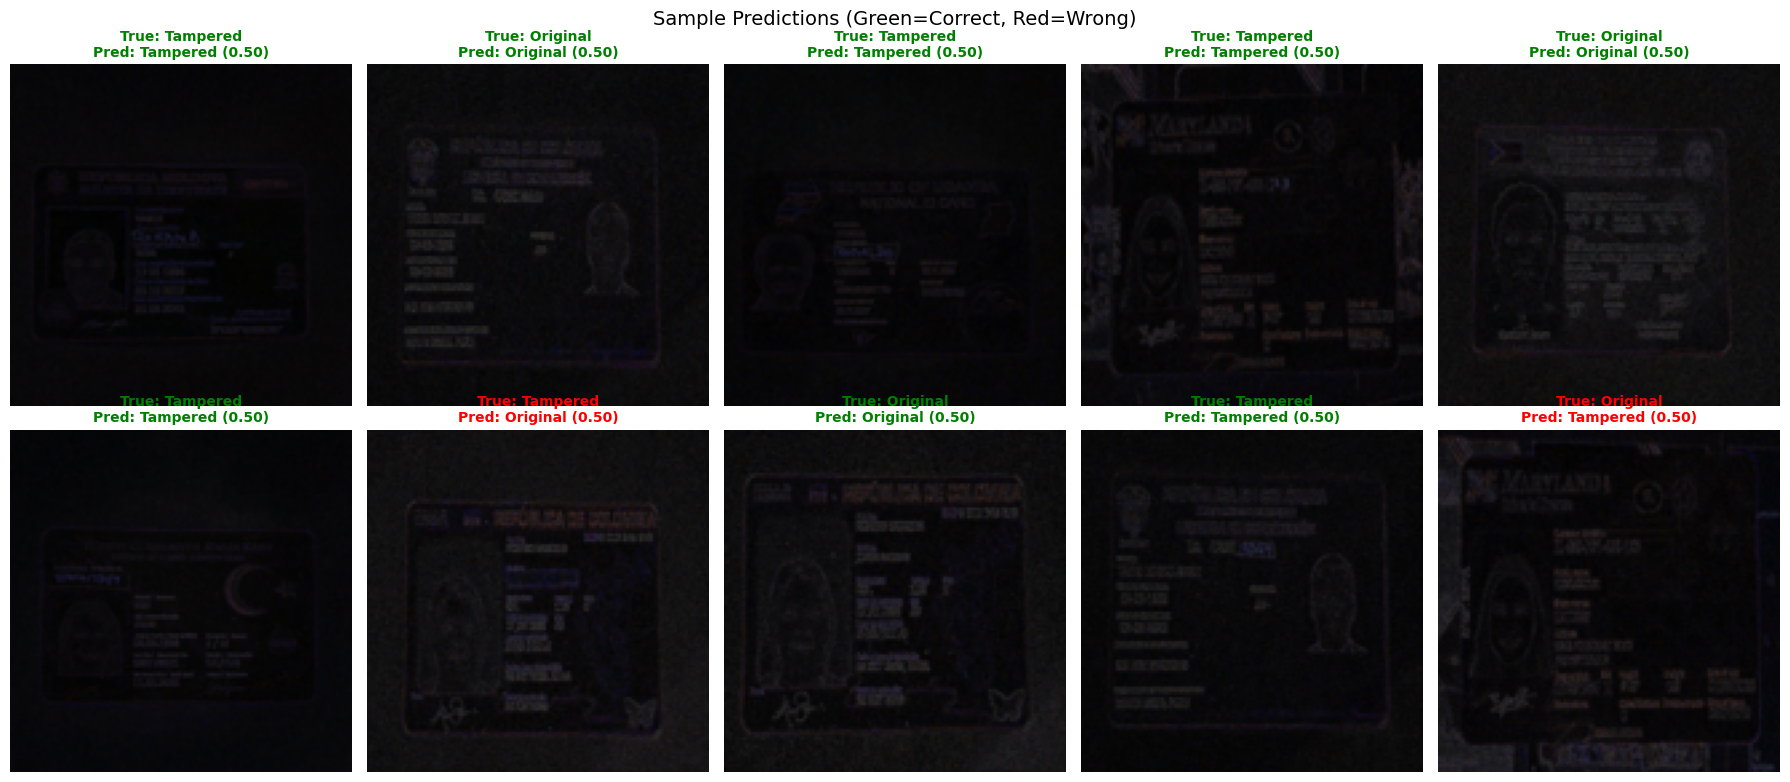


Correct: 13/17 (76.5%)


In [22]:
n_samples = min(10, len(X_test_np))
sample_idx = np.random.choice(len(X_test_np), n_samples, replace=False)

cols = 5
rows = (n_samples + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
if rows == 1:
    axes = axes.reshape(1, -1)

class_names = ['Original', 'Tampered']

for i, idx in enumerate(sample_idx):
    r, c = divmod(i, cols)
    img = X_test_np[idx]  # channels-last for display
    true_label = Y_true_classes[idx]
    pred_label = Y_pred_classes[idx]
    confidence = Y_pred_prob[idx][pred_label]
    
    axes[r, c].imshow(img)
    correct = true_label == pred_label
    color = 'green' if correct else 'red'
    axes[r, c].set_title(
        f"True: {class_names[true_label]}\nPred: {class_names[pred_label]} ({confidence:.2f})",
        fontsize=10, color=color, fontweight='bold'
    )
    axes[r, c].axis('off')

# Hide empty subplots
for i in range(n_samples, rows * cols):
    r, c = divmod(i, cols)
    axes[r, c].axis('off')

fig.suptitle('Sample Predictions (Green=Correct, Red=Wrong)', fontsize=14)
plt.tight_layout()
plt.show()

# Summary
correct_count = np.sum(Y_pred_classes == Y_true_classes)
print(f"\nCorrect: {correct_count}/{len(Y_true_classes)} ({correct_count/len(Y_true_classes)*100:.1f}%)")

## 14. Save the Trained Model

In [23]:
os.makedirs('model', exist_ok=True)

# Save PyTorch model (.pth state dict)
model_name = f"tampering_detection_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
model_path = os.path.join('model', model_name)
torch.save(model.state_dict(), model_path)
print(f"Model state dict saved: {model_path}")

# Save full model (for easy loading)
full_model_path = os.path.join('model', 'tampering_detection_full.pth')
torch.save(model, full_model_path)
print(f"Full model saved: {full_model_path}")

# Save training history
history_path = os.path.join('model', 'training_history.json')
history_dict = {k: [float(v) for v in vals] for k, vals in history.items()}
with open(history_path, 'w') as f:
    json.dump(history_dict, f, indent=2)
print(f"History saved: {history_path}")

# Save config
config = {
    'image_size': IMAGE_SIZE,
    'ela_quality': 90,
    'classes': {0: 'original', 1: 'tampered'},
    'total_images': len(df_valid),
    'train_size': len(X_train_np),
    'val_size': len(X_val_np),
    'test_size': len(X_test_np),
    'best_val_accuracy': float(max(history['val_accuracy'])),
    'test_accuracy': float(test_acc),
    'model_file': model_name,
    'framework': 'pytorch',
    'trained_on': datetime.now().isoformat()
}
config_path = os.path.join('model', 'config.json')
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)
print(f"Config saved: {config_path}")

# Model size
model_size_mb = os.path.getsize(model_path) / 1e6
print(f"\nModel size: {model_size_mb:.1f} MB")

Model state dict saved: model\tampering_detection_20260224_184028.pth
Full model saved: model\tampering_detection_full.pth
History saved: model\training_history.json
Config saved: model\config.json

Model size: 1.7 MB


## Quick Reference: How to Use the Saved Model

```python
import torch
import numpy as np
from PIL import Image, ImageChops, ImageEnhance

# Recreate model class (same architecture) then load weights
model = torch.load('model/tampering_detection_full.pth', map_location='cpu')
model.eval()

def predict_tampering(image_path):
    im = Image.open(image_path).convert('RGB')
    im.save('temp.jpg', 'JPEG', quality=90)
    resaved = Image.open('temp.jpg')
    ela = ImageChops.difference(im, resaved)
    extrema = ela.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max(max_diff, 1)
    ela = ImageEnhance.Brightness(ela).enhance(scale)
    img = np.array(ela.resize((128, 128))) / 255.0
    # Convert to tensor: channels-first
    X = torch.FloatTensor(img.transpose(2, 0, 1)).unsqueeze(0)
    with torch.no_grad():
        output = model(X)
        probs = torch.softmax(output, dim=1).numpy()[0]
    label = 'Tampered' if probs[1] > probs[0] else 'Original'
    confidence = max(probs)
    return label, confidence

label, conf = predict_tampering('path/to/image.jpg')
print(f"{label} (confidence: {conf:.2f})")
```